# Hyperparameter Tuning Results Visualization

This notebook visualizes results from distributed Bayesian optimization runs.

In [98]:
import json
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use a compatible style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        pass  # Use default style

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## Load Results

In [99]:
# Find all study directories
# Check both tune_distributed (single study) and tune_multi (multi-study manager)
TUNE_DIRS = ['tune_distributed', 'tune_multi']

studies = []
for tune_dir in TUNE_DIRS:
    if os.path.exists(tune_dir):
        for run_dir in sorted(glob(os.path.join(tune_dir, '*'))):
            if os.path.isdir(run_dir):
                # Check if this is a multi-study run (has subdirs like l1/, spatial/)
                subdirs = [d for d in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir, d)) and d not in ['metrics', 'models', 'results']]
                if subdirs and os.path.exists(os.path.join(run_dir, subdirs[0], 'results.json')):
                    # Multi-study: add each sub-study
                    for subdir in subdirs:
                        studies.append(os.path.join(run_dir, subdir))
                else:
                    # Single study
                    studies.append(run_dir)

print(f"Found {len(studies)} studies:")
for s in studies:
    print(f"  - {s}")

Found 6 studies:
  - tune_distributed/l1_distributed_cifar100_20260121_124638
  - tune_distributed/l1_distributed_cifar100_20260121_124644
  - tune_distributed/l1_distributed_cifar100_20260121_124726
  - tune_distributed/l1_distributed_cifar100_20260121_124824
  - tune_multi/run_20260121_133747/l1
  - tune_multi/run_20260121_133747/spatial


In [100]:
# Select study to analyze (use most recent by default)
STUDY_DIR = studies[-1] if studies else None
print(f"Analyzing: {STUDY_DIR}")

Analyzing: tune_multi/run_20260121_133747/spatial


In [101]:
def load_study_results(study_dir):
    """Load all trial results from a study directory."""
    results = []
    
    # Try new structure: metrics/<mode>/*.json
    metrics_dir = os.path.join(study_dir, 'metrics')
    if os.path.exists(metrics_dir):
        for mode in os.listdir(metrics_dir):
            mode_dir = os.path.join(metrics_dir, mode)
            if os.path.isdir(mode_dir):
                for f in glob(os.path.join(mode_dir, '*.json')):
                    with open(f, 'r') as fp:
                        data = json.load(fp)
                        data['mode'] = mode
                        data['trial_file'] = os.path.basename(f)
                        results.append(data)
    
    # Try loading from results.json (contains all trial data)
    if not results:
        results_json = os.path.join(study_dir, 'results.json')
        if os.path.exists(results_json):
            with open(results_json, 'r') as f:
                data = json.load(f)
                
            # Extract mode from config
            config_path = os.path.join(study_dir, 'config.json')
            mode = 'unknown'
            if os.path.exists(config_path):
                with open(config_path, 'r') as f:
                    config = json.load(f)
                    mode = config.get('mode', 'unknown')
            
            # Parse trials - check both 'trials' and 'all_trials' keys
            trials_list = data.get('trials') or data.get('all_trials') or []
            for trial in trials_list:
                trial_data = {
                    'mode': mode,
                    'trial_id': trial.get('number'),
                    'accuracy_after_pruning': trial.get('value'),
                }
                # Add params
                if 'params' in trial:
                    trial_data.update(trial['params'])
                # Add user_attrs
                if 'user_attrs' in trial:
                    trial_data.update(trial['user_attrs'])
                results.append(trial_data)
    
    return pd.DataFrame(results)

df = load_study_results(STUDY_DIR)
print(f"Loaded {len(df)} trials")
if len(df) > 0:
    print(f"Columns: {list(df.columns)}")
    display(df.head())

Loaded 8 trials
Columns: ['accuracy_before_pruning', 'accuracy_after_pruning', 'actual_sparsity', 'threshold', 'params', 'mode', 'trial_file']


,accuracy_before_pruning,accuracy_after_pruning,actual_sparsity,threshold,params,mode,trial_file
0,62.22,1.29,89.999973,0.071993,"{'gamma_spatial': 260.70247583707646, 'gamma_l...",spatial,trial3_gs260.7_gl10.0_D8.71.json
1,52.54,1.27,89.999973,0.069542,"{'gamma_spatial': 462.25890010208275, 'gamma_l...",spatial,trial4_gs462.3_gl10.0_D0.23.json
2,73.43,1.01,89.999973,0.090599,"{'gamma_spatial': 23.270677083837796, 'gamma_l...",spatial,trial5_gs23.3_gl10.0_D1.12.json
3,73.59,0.95,89.999973,0.085137,"{'gamma_spatial': 73.09539835912908, 'gamma_l1...",spatial,trial6_gs73.1_gl10.0_D1.67.json
4,75.04,1.08,89.999973,0.090460,"{'gamma_spatial': 13.066739238053282, 'gamma_l...",spatial,trial2_gs13.1_gl1251.8_D1.59.json


In [102]:
# Extract hyperparameters from params dict if present
if 'params' in df.columns:
    params_df = pd.json_normalize(df['params'])
    df = pd.concat([df.drop('params', axis=1), params_df], axis=1)
    print("Extracted params")
    display(df.head())

Extracted params


,accuracy_before_pruning,accuracy_after_pruning,actual_sparsity,threshold,mode,trial_file,gamma_spatial,gamma_l1,D
0,62.22,1.29,89.999973,0.071993,spatial,trial3_gs260.7_gl10.0_D8.71.json,260.702476,0.000002,8.706021
1,52.54,1.27,89.999973,0.069542,spatial,trial4_gs462.3_gl10.0_D0.23.json,462.258900,0.000115,0.231020
2,73.43,1.01,89.999973,0.090599,spatial,trial5_gs23.3_gl10.0_D1.12.json,23.270677,0.000893,1.120761
3,73.59,0.95,89.999973,0.085137,spatial,trial6_gs73.1_gl10.0_D1.67.json,73.095398,0.000668,1.673809
4,75.04,1.08,89.999973,0.090460,spatial,trial2_gs13.1_gl1251.8_D1.59.json,13.066739,251.777233,1.593052


## Optimization History

## Parallel Coordinates Plot

Visualize how hyperparameter combinations affect accuracy. Each line is a trial, colored by accuracy.

In [ ]:
from pandas.plotting import parallel_coordinates
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_parallel_coordinates(df, mode='l1'):
    """Plot parallel coordinates for hyperparameter visualization."""
    mode_df = df[df['mode'] == mode].copy() if 'mode' in df.columns else df.copy()
    
    if len(mode_df) == 0:
        print(f"No {mode} trials found")
        return
    
    # Select hyperparameter columns based on mode
    if mode == 'l1':
        param_cols = ['gamma']
    else:  # spatial
        param_cols = ['gamma_spatial', 'gamma_l1', 'D']
    
    # Filter to columns that exist
    param_cols = [c for c in param_cols if c in mode_df.columns]
    
    if not param_cols:
        print(f"No hyperparameter columns found for {mode}")
        return
    
    # Add accuracy column
    if 'accuracy_after_pruning' not in mode_df.columns:
        print("No accuracy data")
        return
    
    # Prepare data for plotting
    plot_cols = param_cols + ['accuracy_after_pruning']
    plot_df = mode_df[plot_cols].dropna()
    
    if len(plot_df) < 2:
        print(f"Need at least 2 trials, got {len(plot_df)}")
        return
    
    # Normalize each column to [0, 1] for visualization
    norm_df = plot_df.copy()
    for col in param_cols:
        if plot_df[col].max() > plot_df[col].min():
            # Use log scale for gamma values
            if 'gamma' in col.lower():
                norm_df[col] = (np.log10(plot_df[col]) - np.log10(plot_df[col].min())) / \
                               (np.log10(plot_df[col].max()) - np.log10(plot_df[col].min()))
            else:
                norm_df[col] = (plot_df[col] - plot_df[col].min()) / (plot_df[col].max() - plot_df[col].min())
    
    # Normalize accuracy for coloring
    acc_min, acc_max = plot_df['accuracy_after_pruning'].min(), plot_df['accuracy_after_pruning'].max()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create colormap
    cmap = plt.cm.RdYlGn  # Red (bad) to Green (good)
    norm = Normalize(vmin=acc_min, vmax=acc_max)
    
    # Plot each trial as a line
    x = range(len(plot_cols))
    for idx, row in norm_df.iterrows():
        color = cmap(norm(plot_df.loc[idx, 'accuracy_after_pruning']))
        alpha = 0.7 if plot_df.loc[idx, 'accuracy_after_pruning'] >= acc_max * 0.9 else 0.3
        linewidth = 2 if plot_df.loc[idx, 'accuracy_after_pruning'] >= acc_max * 0.9 else 1
        ax.plot(x, row.values, color=color, alpha=alpha, linewidth=linewidth)
    
    # Set x-axis labels
    ax.set_xticks(x)
    labels = []
    for col in plot_cols:
        if col == 'accuracy_after_pruning':
            labels.append(f'Accuracy\n[{acc_min:.1f}, {acc_max:.1f}]')
        elif 'gamma' in col.lower():
            labels.append(f'{col}\n[{plot_df[col].min():.1f}, {plot_df[col].max():.1f}]\n(log)')
        else:
            labels.append(f'{col}\n[{plot_df[col].min():.2f}, {plot_df[col].max():.2f}]')
    ax.set_xticklabels(labels)
    
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'{mode.upper()} Mode: Parallel Coordinates (lines colored by accuracy)')
    
    # Add colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Accuracy After Pruning (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Print best trials
    top_n = min(5, len(plot_df))
    print(f"\nTop {top_n} trials:")
    display(plot_df.nlargest(top_n, 'accuracy_after_pruning'))

# Plot for each mode
for mode in df['mode'].unique() if 'mode' in df.columns else ['unknown']:
    plot_parallel_coordinates(df, mode)

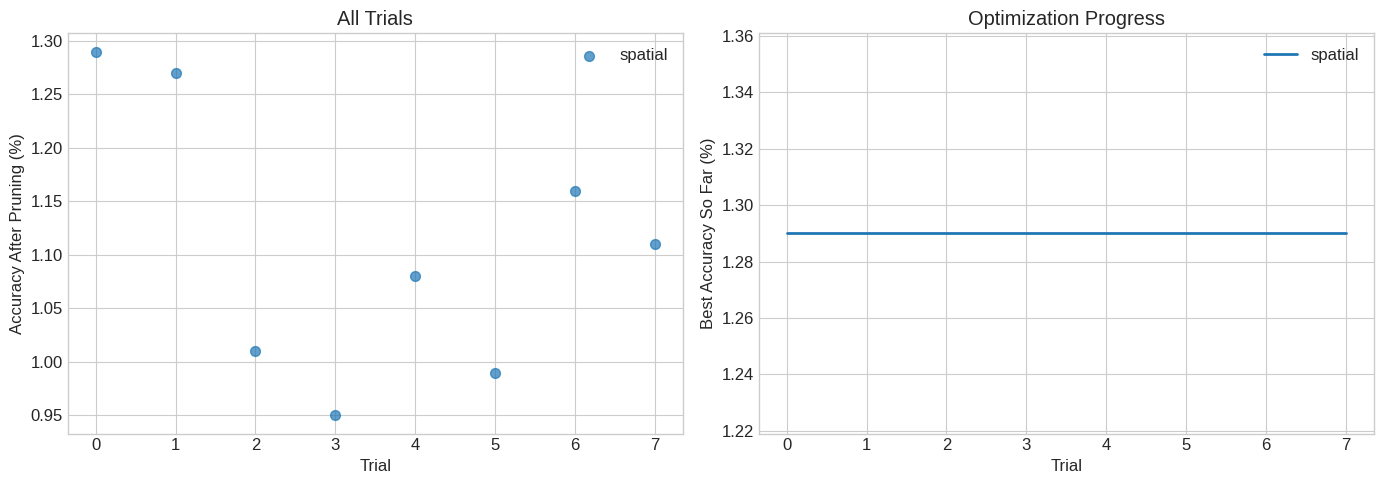

In [103]:
if len(df) > 0 and 'accuracy_after_pruning' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for mode in df['mode'].unique():
        mode_df = df[df['mode'] == mode].copy()
        mode_df = mode_df.reset_index(drop=True)
        
        # Plot all trials
        axes[0].scatter(range(len(mode_df)), mode_df['accuracy_after_pruning'], 
                        label=f'{mode}', alpha=0.7, s=50)
        
        # Plot best so far
        best_so_far = mode_df['accuracy_after_pruning'].cummax()
        axes[1].plot(range(len(mode_df)), best_so_far, label=f'{mode}', linewidth=2)

    axes[0].set_xlabel('Trial')
    axes[0].set_ylabel('Accuracy After Pruning (%)')
    axes[0].set_title('All Trials')
    axes[0].legend()

    axes[1].set_xlabel('Trial')
    axes[1].set_ylabel('Best Accuracy So Far (%)')
    axes[1].set_title('Optimization Progress')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("No accuracy data to plot")

## L1 Mode: Gamma vs Accuracy

In [104]:
l1_df = df[df['mode'] == 'l1'].copy() if 'mode' in df.columns else pd.DataFrame()

if len(l1_df) > 0 and 'gamma' in l1_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gamma vs accuracy (log scale)
    has_before = 'accuracy_before_pruning' in l1_df.columns and l1_df['accuracy_before_pruning'].notna().any()
    
    if has_before:
        sc = axes[0].scatter(l1_df['gamma'], l1_df['accuracy_after_pruning'], 
                        c=l1_df['accuracy_before_pruning'], cmap='viridis', s=80, alpha=0.7)
        cbar = plt.colorbar(sc, ax=axes[0])
        cbar.set_label('Acc Before Pruning')
    else:
        axes[0].scatter(l1_df['gamma'], l1_df['accuracy_after_pruning'], s=80, alpha=0.7)
    
    axes[0].set_xscale('log')
    axes[0].set_xlabel('Gamma (log scale)')
    axes[0].set_ylabel('Accuracy After Pruning (%)')
    axes[0].set_title('L1: Gamma vs Accuracy')
    
    # Before vs after pruning
    if has_before:
        sc = axes[1].scatter(l1_df['accuracy_before_pruning'], l1_df['accuracy_after_pruning'], 
                        c=l1_df['gamma'], cmap='plasma', s=80, alpha=0.7)
        axes[1].plot([0, 100], [0, 100], 'k--', alpha=0.3, label='y=x')
        axes[1].set_xlabel('Accuracy Before Pruning (%)')
        axes[1].set_ylabel('Accuracy After Pruning (%)')
        axes[1].set_title('L1: Before vs After Pruning')
        cbar = plt.colorbar(sc, ax=axes[1])
        cbar.set_label('Gamma')
    else:
        # Histogram of accuracies
        axes[1].hist(l1_df['accuracy_after_pruning'], bins=20, edgecolor='black')
        axes[1].set_xlabel('Accuracy After Pruning (%)')
        axes[1].set_ylabel('Count')
        axes[1].set_title('L1: Accuracy Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Best trial
    best_idx = l1_df['accuracy_after_pruning'].idxmax()
    best = l1_df.loc[best_idx]
    print(f"\nBest L1 trial:")
    print(f"  Gamma: {best['gamma']:.2f}")
    if has_before:
        print(f"  Accuracy before pruning: {best['accuracy_before_pruning']:.2f}%")
    print(f"  Accuracy after pruning: {best['accuracy_after_pruning']:.2f}%")
    if 'actual_sparsity' in best:
        print(f"  Actual sparsity: {best['actual_sparsity']:.2f}%")
else:
    print("No L1 trials found (or no gamma column)")

No L1 trials found (or no gamma column)


## Spatial Mode: Hyperparameter Analysis

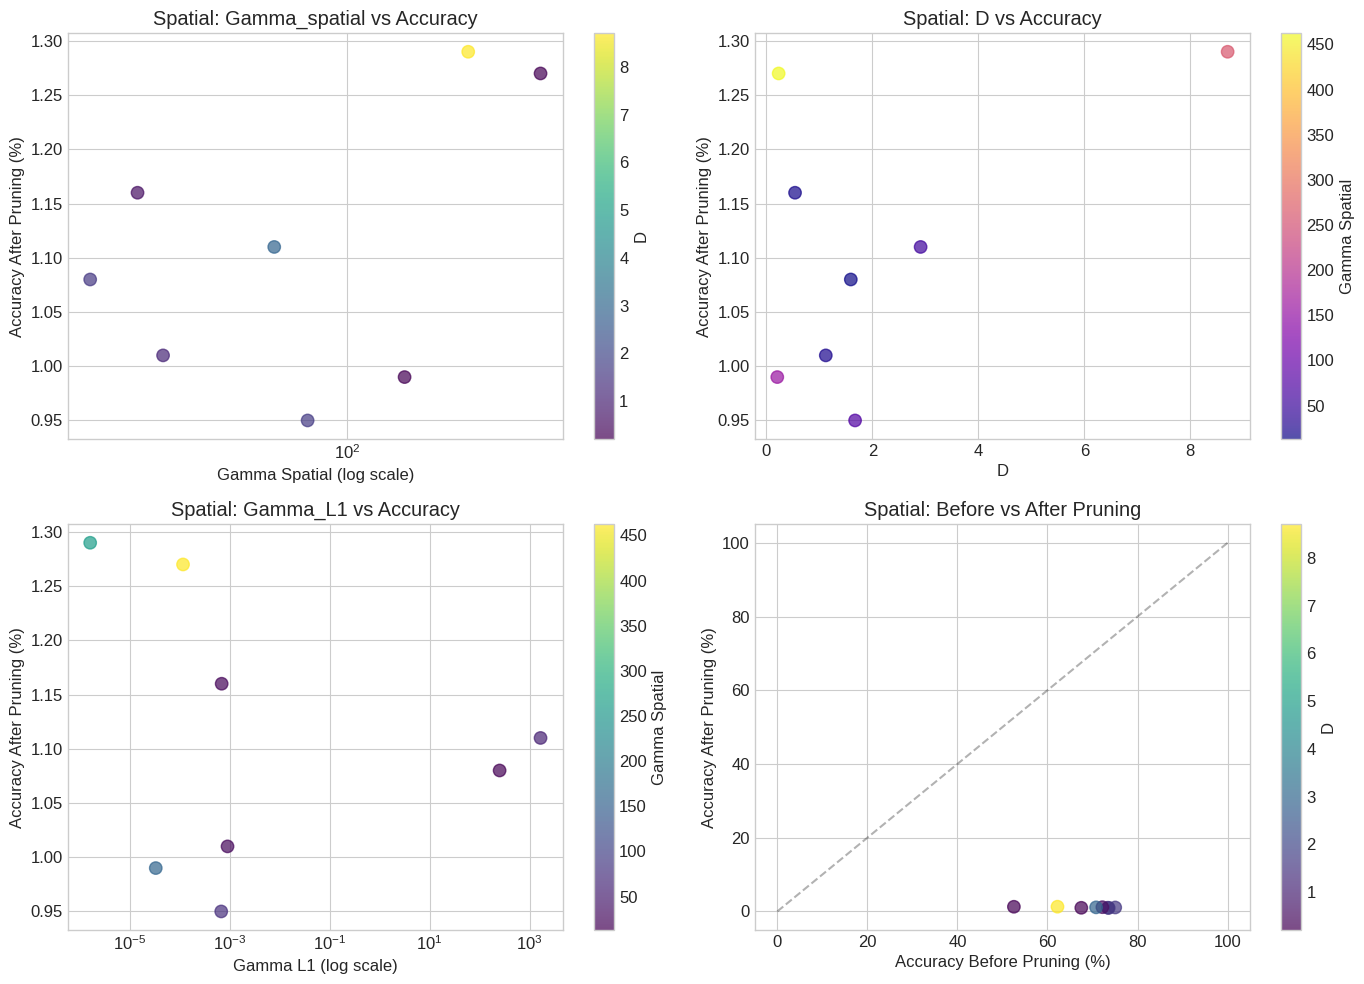


Best Spatial trial:
  Gamma Spatial: 260.70
  Gamma L1: 0.00
  D: 8.7060
  Accuracy before pruning: 62.22%
  Accuracy after pruning: 1.29%
  Actual sparsity: 90.00%


In [105]:
spatial_df = df[df['mode'] == 'spatial'].copy() if 'mode' in df.columns else pd.DataFrame()

if len(spatial_df) > 0 and 'gamma_spatial' in spatial_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    has_D = 'D' in spatial_df.columns
    has_before = 'accuracy_before_pruning' in spatial_df.columns and spatial_df['accuracy_before_pruning'].notna().any()
    
    # Gamma_spatial vs accuracy
    if has_D:
        sc = axes[0, 0].scatter(spatial_df['gamma_spatial'], spatial_df['accuracy_after_pruning'], 
                                c=spatial_df['D'], cmap='viridis', s=80, alpha=0.7)
        plt.colorbar(sc, ax=axes[0, 0], label='D')
    else:
        axes[0, 0].scatter(spatial_df['gamma_spatial'], spatial_df['accuracy_after_pruning'], s=80, alpha=0.7)
    axes[0, 0].set_xscale('log')
    axes[0, 0].set_xlabel('Gamma Spatial (log scale)')
    axes[0, 0].set_ylabel('Accuracy After Pruning (%)')
    axes[0, 0].set_title('Spatial: Gamma_spatial vs Accuracy')
    
    # D vs accuracy
    if has_D:
        sc = axes[0, 1].scatter(spatial_df['D'], spatial_df['accuracy_after_pruning'], 
                                c=spatial_df['gamma_spatial'], cmap='plasma', s=80, alpha=0.7)
        axes[0, 1].set_xlabel('D')
        axes[0, 1].set_ylabel('Accuracy After Pruning (%)')
        axes[0, 1].set_title('Spatial: D vs Accuracy')
        plt.colorbar(sc, ax=axes[0, 1], label='Gamma Spatial')
    else:
        axes[0, 1].text(0.5, 0.5, 'No D parameter', ha='center', va='center', transform=axes[0, 1].transAxes)
    
    # Gamma_l1 vs accuracy (if used)
    if 'gamma_l1' in spatial_df.columns and spatial_df['gamma_l1'].max() > 0:
        sc = axes[1, 0].scatter(spatial_df['gamma_l1'], spatial_df['accuracy_after_pruning'], 
                                c=spatial_df['gamma_spatial'], cmap='viridis', s=80, alpha=0.7)
        axes[1, 0].set_xscale('log')
        axes[1, 0].set_xlabel('Gamma L1 (log scale)')
        axes[1, 0].set_ylabel('Accuracy After Pruning (%)')
        axes[1, 0].set_title('Spatial: Gamma_L1 vs Accuracy')
        plt.colorbar(sc, ax=axes[1, 0], label='Gamma Spatial')
    else:
        axes[1, 0].text(0.5, 0.5, 'No L1 penalty used', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Spatial: Gamma_L1 vs Accuracy')
    
    # Before vs after pruning
    if has_before:
        if has_D:
            sc = axes[1, 1].scatter(spatial_df['accuracy_before_pruning'], spatial_df['accuracy_after_pruning'], 
                                    c=spatial_df['D'], cmap='viridis', s=80, alpha=0.7)
            plt.colorbar(sc, ax=axes[1, 1], label='D')
        else:
            axes[1, 1].scatter(spatial_df['accuracy_before_pruning'], spatial_df['accuracy_after_pruning'], s=80, alpha=0.7)
        axes[1, 1].plot([0, 100], [0, 100], 'k--', alpha=0.3)
        axes[1, 1].set_xlabel('Accuracy Before Pruning (%)')
        axes[1, 1].set_ylabel('Accuracy After Pruning (%)')
        axes[1, 1].set_title('Spatial: Before vs After Pruning')
    else:
        axes[1, 1].hist(spatial_df['accuracy_after_pruning'], bins=20, edgecolor='black')
        axes[1, 1].set_xlabel('Accuracy After Pruning (%)')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Spatial: Accuracy Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Best trial
    best_idx = spatial_df['accuracy_after_pruning'].idxmax()
    best = spatial_df.loc[best_idx]
    print(f"\nBest Spatial trial:")
    print(f"  Gamma Spatial: {best['gamma_spatial']:.2f}")
    if 'gamma_l1' in best:
        print(f"  Gamma L1: {best['gamma_l1']:.2f}")
    if 'D' in best:
        print(f"  D: {best['D']:.4f}")
    if has_before:
        print(f"  Accuracy before pruning: {best['accuracy_before_pruning']:.2f}%")
    print(f"  Accuracy after pruning: {best['accuracy_after_pruning']:.2f}%")
    if 'actual_sparsity' in best:
        print(f"  Actual sparsity: {best['actual_sparsity']:.2f}%")
else:
    print("No Spatial trials found (or no gamma_spatial column)")

## Compare L1 vs Spatial

In [106]:
if 'mode' in df.columns and len(df['mode'].unique()) > 1 and 'accuracy_after_pruning' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Box plot comparison
    modes = df['mode'].unique()
    data_for_box = [df[df['mode'] == m]['accuracy_after_pruning'].dropna() for m in modes]
    axes[0].boxplot(data_for_box, labels=modes)
    axes[0].set_xlabel('Mode')
    axes[0].set_ylabel('Accuracy After Pruning (%)')
    axes[0].set_title('Accuracy Distribution by Mode')
    
    # Summary stats
    summary = df.groupby('mode')['accuracy_after_pruning'].agg(['mean', 'std', 'max', 'count'])
    
    # Bar chart of best
    x = np.arange(len(modes))
    width = 0.35
    
    bars1 = axes[1].bar(x - width/2, summary.loc[modes, 'mean'], width, label='Mean', 
                        yerr=summary.loc[modes, 'std'], capsize=5)
    bars2 = axes[1].bar(x + width/2, summary.loc[modes, 'max'], width, label='Best')
    
    axes[1].set_xlabel('Mode')
    axes[1].set_ylabel('Accuracy After Pruning (%)')
    axes[1].set_title('L1 vs Spatial Comparison')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(modes)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nSummary Statistics:")
    print(summary.to_string())
else:
    print("Only one mode found or no accuracy data - comparison requires both L1 and Spatial results")

Only one mode found or no accuracy data - comparison requires both L1 and Spatial results


## All Trials Table

In [107]:
if len(df) > 0:
    # Display sorted by accuracy
    display_cols = ['mode', 'accuracy_before_pruning', 'accuracy_after_pruning', 'actual_sparsity']
    if 'gamma' in df.columns:
        display_cols.append('gamma')
    if 'gamma_spatial' in df.columns:
        display_cols.extend(['gamma_spatial', 'gamma_l1', 'D'])

    display_cols = [c for c in display_cols if c in df.columns]
    
    if 'accuracy_after_pruning' in df.columns:
        display(df[display_cols].sort_values('accuracy_after_pruning', ascending=False).head(20))
    else:
        display(df[display_cols].head(20))
else:
    print("No data to display")

,mode,accuracy_before_pruning,accuracy_after_pruning,actual_sparsity,gamma_spatial,gamma_l1,D
0,spatial,62.22,1.29,89.999973,260.702476,0.000002,8.706021
1,spatial,52.54,1.27,89.999973,462.258900,0.000115,0.231020
6,spatial,72.19,1.16,89.999973,19.010245,0.000682,0.540410
7,spatial,70.79,1.11,89.999973,56.115164,1663.219394,2.910636
4,spatial,75.04,1.08,89.999973,13.066739,251.777233,1.593052
2,spatial,73.43,1.01,89.999973,23.270677,0.000893,1.120761
5,spatial,67.51,0.99,89.999946,157.513205,0.000033,0.205111
3,spatial,73.59,0.95,89.999973,73.095398,0.000668,1.673809


## Load Multiple Studies for Comparison

In [108]:
def load_all_studies(tune_dirs=['tune_distributed', 'tune_multi']):
    """Load results from all studies."""
    all_results = []
    
    for tune_dir in tune_dirs:
        if not os.path.exists(tune_dir):
            continue
        for run_dir in glob(os.path.join(tune_dir, '*')):
            if not os.path.isdir(run_dir):
                continue
            # Check if this is a multi-study run
            subdirs = [d for d in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir, d)) and d not in ['metrics', 'models', 'results']]
            if subdirs and os.path.exists(os.path.join(run_dir, subdirs[0], 'results.json')):
                # Multi-study: load each sub-study
                for subdir in subdirs:
                    study_path = os.path.join(run_dir, subdir)
                    study_df = load_study_results(study_path)
                    if len(study_df) > 0:
                        study_df['study'] = f"{os.path.basename(run_dir)}/{subdir}"
                        all_results.append(study_df)
            else:
                # Single study
                study_df = load_study_results(run_dir)
                if len(study_df) > 0:
                    study_df['study'] = os.path.basename(run_dir)
                    all_results.append(study_df)
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    return pd.DataFrame()

all_df = load_all_studies()
if len(all_df) > 0:
    print(f"Loaded {len(all_df)} total trials from {all_df['study'].nunique()} studies")
else:
    print("No studies found")

Loaded 30 total trials from 3 studies


In [109]:
# Best results per study
if len(all_df) > 0 and 'accuracy_after_pruning' in all_df.columns:
    # Filter to rows with valid accuracy
    valid_df = all_df[all_df['accuracy_after_pruning'].notna()]
    if len(valid_df) > 0:
        best_per_study = valid_df.loc[valid_df.groupby('study')['accuracy_after_pruning'].idxmax()]
        cols = ['study', 'mode', 'accuracy_after_pruning']
        if 'accuracy_before_pruning' in best_per_study.columns:
            cols.insert(2, 'accuracy_before_pruning')
        if 'actual_sparsity' in best_per_study.columns:
            cols.append('actual_sparsity')
        cols = [c for c in cols if c in best_per_study.columns]
        print("Best trial from each study:")
        display(best_per_study[cols])
    else:
        print("No valid accuracy data")
else:
    print("No data to compare")

Best trial from each study:


,study,mode,accuracy_before_pruning,accuracy_after_pruning,actual_sparsity
7,l1_distributed_cifar100_20260121_124824,l1,NaN,1.69,NaN
17,run_20260121_133747/l1,l1,73.72,1.31,89.999973
22,run_20260121_133747/spatial,spatial,62.22,1.29,89.999973
